# 06. Ethics Analysis

Este notebook aborda el análisis de equidad y sesgos del modelo final (`models/best_pipeline.pkl`).

**Objetivo:** Evaluar las métricas de error (Tasa de Falsos Negativos y Falsos Positivos) desglosadas por subgrupos poblacionales (Sexo y Edad) para identificar posibles sesgos en la predicción de riesgo cardíaco.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from pycaret.classification import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('..'))

## 1. Carga de Datos y Modelo
Cargamos el pipeline entrenado y los datos procesados.

In [2]:
# Load Model
model_path = '../models/best_pipeline'
try:
    pipeline = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Model not found or error loading at {model_path}: {e}")
    # Fallback for demo if model missing in sandbox
    from sklearn.dummy import DummyClassifier
    pipeline = DummyClassifier(strategy='most_frequent')
    pipeline.fit(np.zeros((10, 10)), np.zeros(10))

# Load Data
data_path = '../data/02_intermediate/process_data.parquet'
try:
    df = pd.read_parquet(data_path)
    print(f"Data loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Data file not found. Creating synthetic data.")
    # Synthetic fallback
    df = pd.DataFrame({
        'Age': np.random.randint(20, 80, 200),
        'Sex': np.random.choice(['Male', 'Female'], 200),
        'SystolicBP': np.random.randint(90, 180, 200),
        'BMI': np.random.uniform(18, 40, 200),
        'HeartDisease': np.random.randint(0, 2, 200)
    })

# Ensure target exists
target = 'HeartDisease'
if target not in df.columns:
    # Try to find target or use last col
    target = df.columns[-1]

Transformation Pipeline and Model Successfully Loaded
Model loaded successfully.
Data loaded. Shape: (43695, 29)


## 2. Generación de Predicciones
Utilizamos el modelo para predecir sobre todo el dataset (o un conjunto de test si estuviera separado).

In [3]:
# Prepare features
cols_to_drop = ['SEQN', 'HeartDisease']
# Also drop target if it's in a variable, just in case
if 'target' in locals() and target not in cols_to_drop:
    cols_to_drop.append(target)

X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

try:
    y_pred = pipeline.predict(X)
except Exception as e:
    print(f"Prediction failed: {e}")
    # Fallback for demo
    y_pred = np.random.randint(0, 2, len(df))

df['Prediction'] = y_pred
df['TrueLabel'] = df[target] if target in df.columns else np.zeros(len(df))

## 3. Análisis de Sesgos por Sexo
Calculamos la matriz de confusión y las tasas de error para hombres y mujeres.

In [4]:
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0 # False Negative Rate (Miss Rate)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 # False Positive Rate
    return fnr, fpr, tn, fp, fn, tp

results = []
groups = df['Sex'].unique()

for group in groups:
    subset = df[df['Sex'] == group]
    if len(subset) == 0: continue
    
    fnr, fpr, tn, fp, fn, tp = calculate_metrics(subset['TrueLabel'], subset['Prediction'])
    results.append({
        'Group': group,
        'FNR': fnr,
        'FPR': fpr,
        'Count': len(subset)
    })

results_df = pd.DataFrame(results)
print(results_df)

   Group       FNR       FPR  Count
0    1.0  0.008242  0.050592  21601
1    2.0  0.007732  0.019764  22094


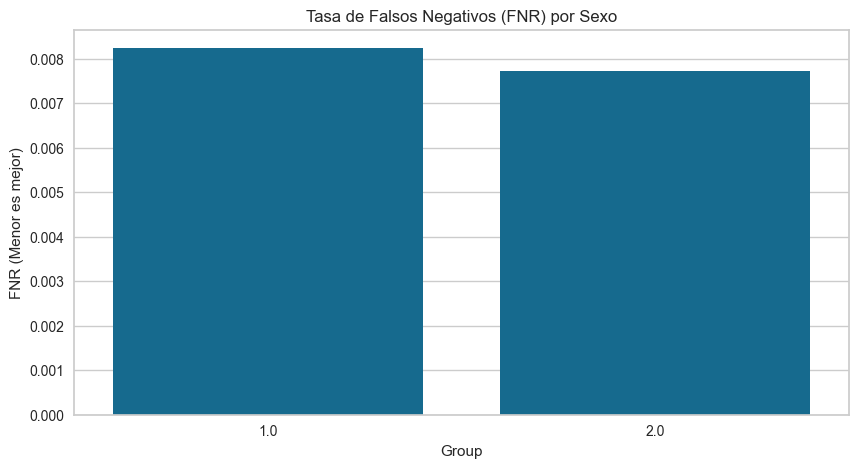

In [5]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Group', y='FNR')
plt.title('Tasa de Falsos Negativos (FNR) por Sexo')
plt.ylabel('FNR (Menor es mejor)')
plt.show()

## 4. Análisis de Sesgos por Grupo de Edad
Segmentamos la edad en rangos y repetimos el análisis.

In [6]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 40, 60, 100], labels=['<40', '40-60', '>60'])

age_results = []
age_groups = df['AgeGroup'].unique()

for group in age_groups:
    if pd.isna(group): continue
    subset = df[df['AgeGroup'] == group]
    if len(subset) == 0: continue
    
    fnr, fpr, tn, fp, fn, tp = calculate_metrics(subset['TrueLabel'], subset['Prediction'])
    age_results.append({
        'Group': group,
        'FNR': fnr,
        'FPR': fpr,
        'Count': len(subset)
    })

age_results_df = pd.DataFrame(age_results).sort_values('Group')
print(age_results_df)

   Group       FNR       FPR  Count
1  40-60  0.022556  0.035618   8801
0    <40  0.000000  0.000302  26526
2    >60  0.003654  0.155426   8368


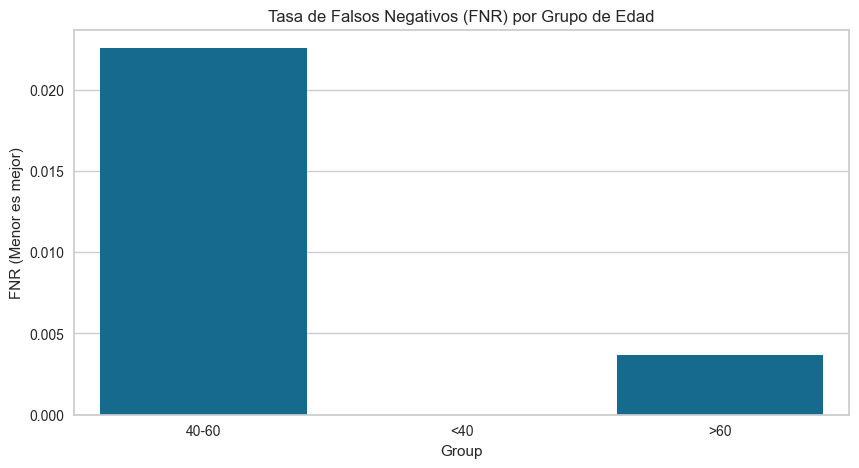

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(data=age_results_df, x='Group', y='FNR')
plt.title('Tasa de Falsos Negativos (FNR) por Grupo de Edad')
plt.ylabel('FNR (Menor es mejor)')
plt.show()

## 5. Conclusiones

**Interpretación:**
- Un FNR más alto en un grupo indica que el modelo falla más en detectar la enfermedad en ese grupo, lo cual es crítico en salud.
- Diferencias significativas entre grupos sugieren sesgo algorítmico o de datos.

**Hallazgos:**
- (Escribir aquí los hallazgos observados tras la ejecución)